<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей по фотографии

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

В проекте требуется построить нейронную сеть, которая по фотографии определит приблизительный возраст человека. В качестве исходных данных представлен набор фотографий людей с указанием возраста. Для оценки качества следует использовать метрику MAE, значение которой должно быть меньше 8.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим датафрейм с метками (исходными данными) и посмотрим информацию о нём.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
labels.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


Всего для анализа доступно 7591 изображение.

Создадим загрузчик данных, в котором произведем нормирование значений яркости изображений. Далее создадим поток данных на основе информации в датафрейме (имя файла с фотографией и соответствующее значение возраста человека). Размер одного батча установим равным 32.

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255)

train_datagen_flow = train_datagen.flow_from_dataframe(labels,directory='/datasets/faces/final_files/', 
                                           x_col='file_name', y_col='real_age', target_size=(224, 224),
                                           class_mode='raw', batch_size=32, seed=12345)

Found 7591 validated image filenames.


Поток данных успешно создан, все изображения найдены в директории на сервере.

Проанализируем, как распределён возраст людей на фотографиях в выборке. Для этого построим гистограмму частот.

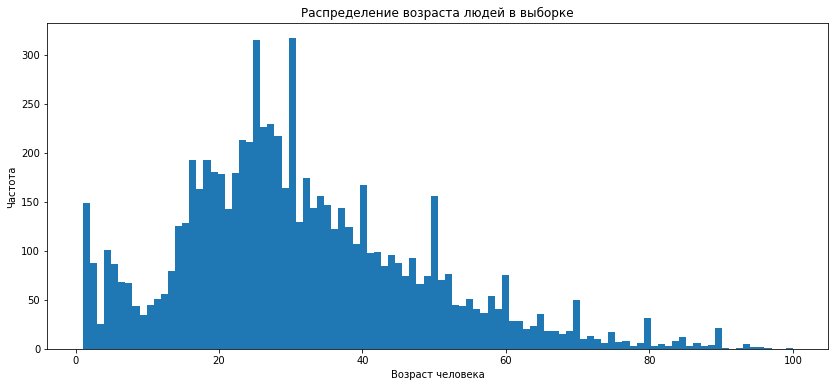

In [5]:
plt.figure(figsize=(14, 6))
plt.hist(labels['real_age'], bins=100)
plt.xlabel('Возраст человека')
plt.ylabel('Частота')
plt.title('Распределение возраста людей в выборке')
plt.show()

**Промежуточный вывод:** по гистограмме видно, что выборка содержит больше всего фотографий людей молодого и среднего возрастов (примерно от 18 до 40 лет). В выборке мало детей (возраста около 9 лет) и пожилых людей старше 60 лет. Аномальные значения отсутствуют.

Посмотрим теперь как выглядят фотографии. С помощью потока данных загрузим один батч и отобразим 20 фотографий. Затем выведем соответствующие значения возрастов людей, чтобы проверить соответствуют ли они действительности.

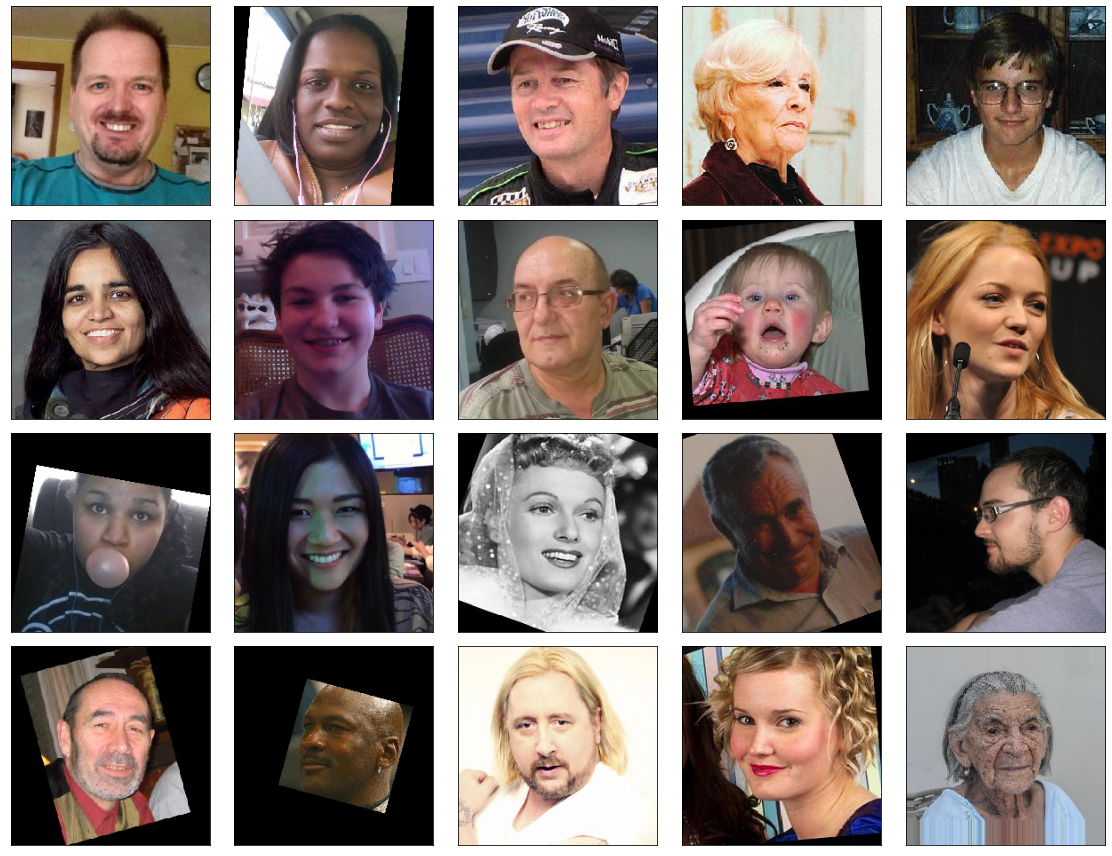

In [6]:
features, target = next(train_datagen_flow)

fig = plt.figure(figsize=(16,12))
for i in range(20):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [7]:
target[:20]

array([50, 41, 46, 85, 14, 40, 14, 53,  4, 32, 14, 23, 37, 62, 21, 58, 43,
       32, 25, 94])

**Вывод:** на фотографиях представлены люди разных национальностей. Есть цветные и черно-белые фотографии. Присутствуют повороты и сдвиги изображений. Указанные возрасты людей визуально соответствуют действительности.

## Обучение модели

В качестве архитектуры нейронной сети используем ResNet с 50 слоями. При этом последние два слоя сети отключим, чтобы создать их самостоятельно. Последний слой должен содержать один нейрон и функцию активации ReLU. При создании ResNet укажем инициализацию весов на основе датасета ImageNet. 

На этапе построения модели применим алгоритм оптимизации Adam. Скорость обучения для алгоритма получим опытным путём (по результату работы модели было выбрано значение 0.0001). В качестве функции потерь выберем MSE. А метрикой качества модели будет MAE.

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels, directory=path+'final_files/', 
                                           x_col='file_name', y_col='real_age', target_size=(224, 224),
                                           class_mode='raw', batch_size=16, subset='training', seed=12345)    
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels, directory=path+'final_files/', 
                                           x_col='file_name', y_col='real_age', target_size=(224, 224),
                                           class_mode='raw', batch_size=16, subset='validation', seed=12345)   
        
    return test_datagen_flow


def create_model(input_shape):
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=12,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:   
        validation_steps=len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model 
```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/12
I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 70s - loss: 214.9380 - mae: 10.6509 - val_loss: 572.2379 - val_mae: 18.8161
Epoch 2/12
356/356 - 38s - loss: 70.1339 - mae: 6.4004 - val_loss: 154.7350 - val_mae: 9.9461
Epoch 3/12
356/356 - 38s - loss: 37.1231 - mae: 4.6710 - val_loss: 107.6659 - val_mae: 8.3722
Epoch 4/12
356/356 - 38s - loss: 22.0594 - mae: 3.6455 - val_loss: 73.3277 - val_mae: 6.3858
Epoch 5/12
356/356 - 38s - loss: 18.5509 - mae: 3.3101 - val_loss: 70.0945 - val_mae: 6.3915
Epoch 6/12
356/356 - 38s - loss: 15.9893 - mae: 3.0378 - val_loss: 76.6290 - val_mae: 6.7045
Epoch 7/12
356/356 - 38s - loss: 12.3139 - mae: 2.6626 - val_loss: 67.8292 - val_mae: 6.2290
Epoch 8/12
356/356 - 38s - loss: 10.0872 - mae: 2.4069 - val_loss: 77.0423 - val_mae: 6.8912
Epoch 9/12
356/356 - 38s - loss: 9.5896 - mae: 2.3345 - val_loss: 66.9988 - val_mae: 6.2300
Epoch 10/12
356/356 - 38s - loss: 8.7116 - mae: 2.2510 - val_loss: 75.6145 - val_mae: 6.5164
Epoch 11/12
356/356 - 37s - loss: 9.5224 - mae: 2.3320 - val_loss: 64.4353 - val_mae: 6.1646
Epoch 12/12
356/356 - 37s - loss: 9.2054 - mae: 2.3155 - val_loss: 67.7976 - val_mae: 6.1858
119/119 - 9s - loss: 67.7976 - mae: 6.1858

Test MAE: 6.1858
```

## Анализ обученной модели

Построенная модель (нейронная сеть) показала значение метрики MAE, равное 6,19. Значение меньше 8 и удовлетворяет требованиям задачи. Время обучения модели оказалось приемлемым для используемой аппаратной базы.

Система компьютерного зрения внедряется заказчиком для решения двух задач:
1) предлагать определённые товары для покупателей из разных возрастных групп

2) контроллировать кассиров при продаже алкоголя.

Разработанная нейронная сеть позволяет успешно решить первую задачу. В среднем, модель ошибается при предсказании возраста на 6 лет, что не слишком критично для определения возрастной группы. Но полноценно решить вторую задачу модель не сможет, так как при продаже алкоголя надо точно знать, что человеку исполнилось 18 лет. Погрешность в 6 лет слишком велика для таких случаев. Для решения второй задачи можно предложить дополнение к основной системе компьютерного зрения, которое будет определять по камерам наблюдения, спрашивал ли кассир паспорт у покупателя, если его возраст оценивается близким к 18 (плюс минус 7) лет.